In [1]:
from config import *
config_chapterextra()
# This is needed to render the plots in this chapter
from plots.chapterextra import *


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import make_regression

from torch.utils.data import DataLoader,TensorDataset,Dataset
from stepbystep.v3 import StepByStep

from data_generation.ball import load_data


2024-03-24 09:43:57.404944: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 09:43:57.461231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 09:43:57.461270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 09:43:57.462590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 09:43:57.470784: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 09:43:57.471291: I tensorflow/core/platform/cpu_feature_guard.cc:1

As the model grow deeper, gradient computed for weights at initial layers become smaller and smaller. its called `vanishing gradients`

## Ball Dataset and Block Model

In [3]:
# Data generation
X,y=load_data(n_points=1000,n_dims=10)


In [4]:
# Data preparation
ball_dataset=TensorDataset(torch.as_tensor(X,dtype=torch.float32),torch.as_tensor(y,dtype=torch.float32))

ball_loader=DataLoader(ball_dataset,batch_size=(len(X)))

In [5]:
# def build_model(n_features,n_layers,hidden_units,activation_fn,use_bn=False):

#     layers=nn.Sequential()
#     # input layer
#     layers.add_module("h1",nn.Linear(n_features,hidden_units))
    
#     # hidden layers
#     for i in range(n_layers-1):
#         layers.add_module(f"a{i+1}",activation_fn)
#         if use_bn:
#             layers.add_module(f"bn{i+1}",nn.BatchNorm1d(hidden_units))
#         layers.add_module(f"h{i+2}",nn.Linear(hidden_units,hidden_units))
    
#     # output layer
#     layers.add_module(f"a{i+2}",activation_fn)
#     if use_bn:
#         layers.add_module(f"bn{i+2}",nn.BatchNorm1d(hidden_units))
#     layers.add_module("o",nn.Linear(hidden_units,1))
#     return layers
    




In [6]:
import torch.nn as nn

class MyModel(nn.Module):
  def __init__(self, in_features, hidden_units):
    super(MyModel, self).__init__()
    self.h1 = nn.Linear(in_features, hidden_units)
    self.a1 = nn.ReLU()
    self.h2 = nn.Linear(hidden_units, hidden_units)
    self.a2 = nn.ReLU()
    self.h3 = nn.Linear(hidden_units, hidden_units)
    self.a3 = nn.ReLU()
    self.h4 = nn.Linear(hidden_units, hidden_units)
    self.a4 = nn.ReLU()
    self.h5 = nn.Linear(hidden_units, hidden_units)
    self.a5 = nn.ReLU()
    self.o = nn.Linear(hidden_units, 1)

  def forward(self, x):
    x = self.a1(self.h1(x))
    x = self.a2(self.h2(x))
    x = self.a3(self.h3(x))
    x = self.a4(self.h4(x))
    x = self.a5(self.h5(x))

    return self.o(x)


In [7]:
# Model  configuration
torch.manual_seed(11)
n_features=X.shape[1]
n_layers=5
hidden_units=100
activation_fn=nn.ReLU()
# model=build_model(n_features,n_layers,hidden_units,activation_fn,use_bn=False)
model=MyModel(10,100)

In [8]:
print(model)

MyModel(
  (h1): Linear(in_features=10, out_features=100, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=100, out_features=100, bias=True)
  (a2): ReLU()
  (h3): Linear(in_features=100, out_features=100, bias=True)
  (a3): ReLU()
  (h4): Linear(in_features=100, out_features=100, bias=True)
  (a4): ReLU()
  (h5): Linear(in_features=100, out_features=100, bias=True)
  (a5): ReLU()
  (o): Linear(in_features=100, out_features=1, bias=True)
)


In [9]:
# Model configuration
loss_fn=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=1e-2)


### Weights, Acivations and Gradients

In [10]:
# Model training
hidden_layers=[f'h{i}' for i in range(1,n_layers+1)]
activation_layers=[f'a{i}' for i in range(1,n_layers+1)]

sbs=StepByStep(model,loss_fn,optimizer)
sbs.set_loaders(ball_loader)

sbs.capture_parameters(hidden_layers)
sbs.capture_gradients(hidden_layers)
sbs.attach_hooks(activation_layers)
sbs.train(1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
list(model.named_modules())[1:]

[('h1', Linear(in_features=10, out_features=100, bias=True)),
 ('a1', ReLU()),
 ('h2', Linear(in_features=100, out_features=100, bias=True)),
 ('a2', ReLU()),
 ('h3', Linear(in_features=100, out_features=100, bias=True)),
 ('a3', ReLU()),
 ('h4', Linear(in_features=100, out_features=100, bias=True)),
 ('a4', ReLU()),
 ('h5', Linear(in_features=100, out_features=100, bias=True)),
 ('a5', ReLU()),
 ('o', Linear(in_features=100, out_features=1, bias=True))]

In [12]:
params,gradients,activations=get_plot_data(train_loader=ball_loader,model=model)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/anushka/Documents/Deep-Learning/Deep Learning with Pytorch/plots/chapterextra.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='layers', y='values', ax=lv.ax, cut=0, palette=lv.palette, scale='width', linewidth=1.5)
/home/anushka/Documents/Deep-Learning/Deep Learning with Pytorch/plots/chapterextra.py:126: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='layers', y='values', ax=lv.ax, cut=0, palette=lv.palette, scale='width', linewidth=1.5)
/home/anushka/Documents/Deep-Learning/Deep Learning with Pytorch/plots/chapterextra.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  lv.ax.set_xticklabels(df.layers.unique())
/home/anushka/Documents/Deep-Learning/Deep Learning

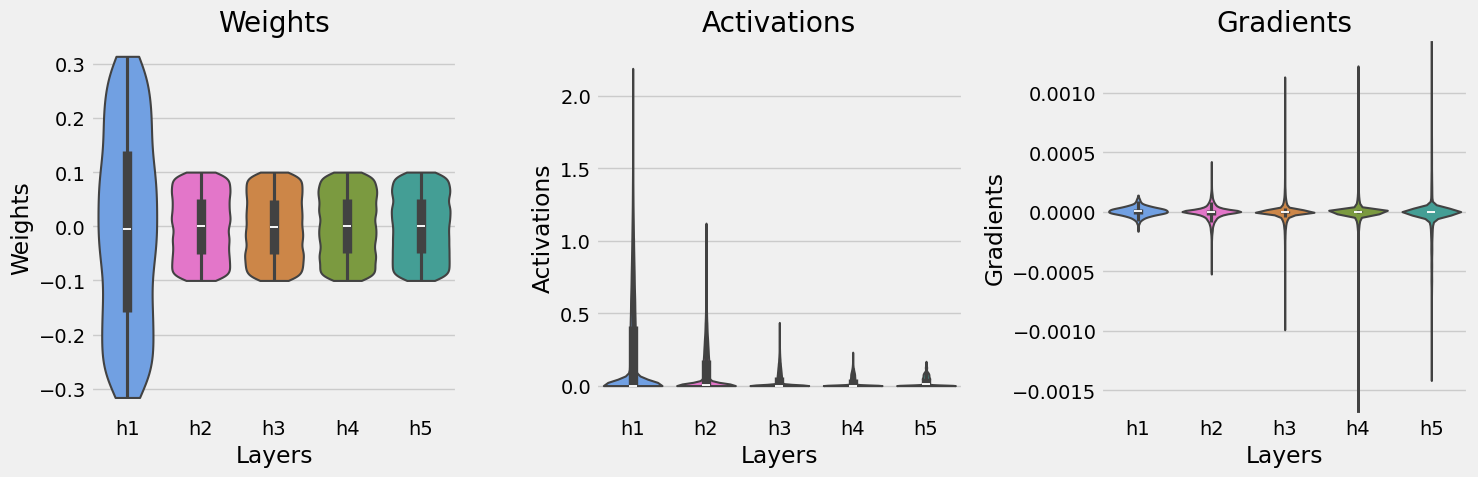

In [13]:
fig = plot_violins(params, gradients, activations)

## Vanishing Gradient  
* Activation values are shrinking as data moves to next layers
* Gradients are larger in last layer and shrink its way back to the first layer.

## Exploading Gradient (less common)
* Activation values grows larger and larger as the data moves to the next layer
* Gradints are smaller in last layer and growing back to the first layer

**How to prevent vanishing gradient problem?**  
* Tweaking variance of the weights keep similar activation distribution across all layers

## Initialization Schemes  
This is a clever way of tweaking the initial distribution of weights (choosing best std for drawing random weights from normal or uniform distribution)  
1. Xavier initialization (use with Tanh)
2. Kaiming initialization (use with ReLU)  


Every default initialization method has its own assumptions

```python
# nn.Linear.reset_parameters()
def reset_parameters(self)->None:
    init.kaiming_uniform_(self.weight,a=math.sqrt(5))
    if self.bias is not None:
        fan_in,_=init._calculate_fan_in_and_fan_out(self.weight)
        bound=1/math.sqrt(fan_in)
        init.uniform_(self.bias,-bound,bound)

```

In [14]:
# initialize a linear layer using kaiming 
def weights_init(m):
    if isinstance(m,nn.Linear):
        nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [15]:
# Model configuration
with torch.no_grad():
    model.apply(weights_init)

### Effect of proper initialization

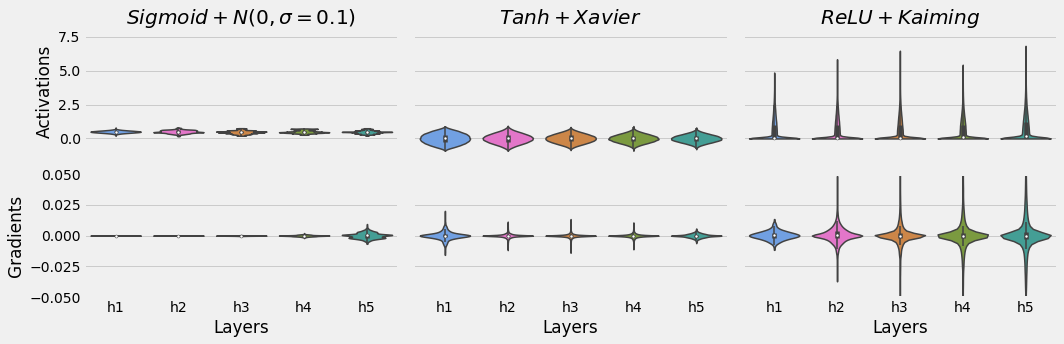

## Batch Normalization

BN are supposed to produce similar distributions of activaton values and gradients

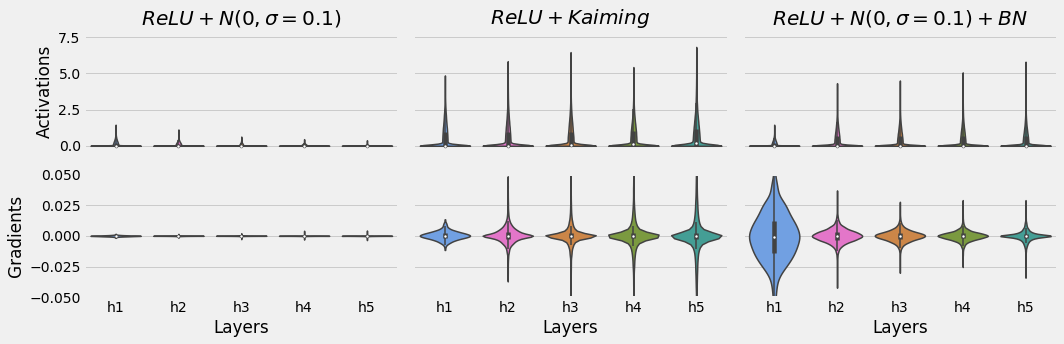

## Exploding Gradients

In [16]:
# Dataset gen
X_reg,y_reg=make_regression(n_samples=1000,n_features=10,noise=0.1,random_state=42)
X_reg=torch.as_tensor(X_reg).float()
y_reg=torch.as_tensor(y_reg).float().view(-1,1)

dataset=TensorDataset(X_reg,y_reg)
train_loader=DataLoader(dataset=dataset,batch_size=32,shuffle=True)

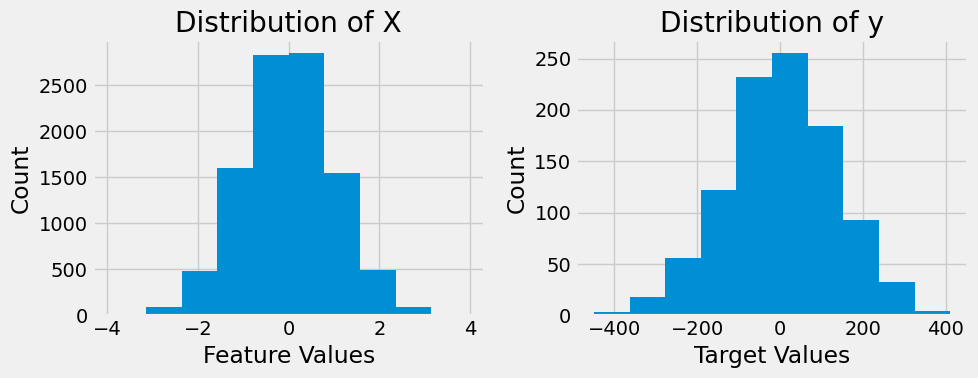

In [17]:
fig = distributions(X_reg, y_reg)

In [18]:
X_reg.shape,y_reg.shape

(torch.Size([1000, 10]), torch.Size([1000, 1]))

In [19]:
# model config
torch.manual_seed(11)
model=nn.Sequential()
model.add_module('fc1',nn.Linear(10,15))
model.add_module('activation',nn.ReLU())
model.add_module('fc2',nn.Linear(15,1))

optimizer=optim.SGD(model.parameters(),lr=0.008)
loss_fn=nn.MSELoss()


In [20]:
sbs_reg=StepByStep(model,loss_fn,optimizer)
sbs_reg.set_loaders(train_loader)
sbs_reg.capture_gradients(['fc1'])
sbs_reg.train(4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
sbs_reg.losses

[7886.56876373291, 9047.295600891113, inf, nan]

In [22]:
grads=np.array(sbs_reg._gradients['fc1']['weight'])
print(grads.mean(axis=(1,2)))

[ 1.22408300e+00  7.59760277e-01 -1.93040267e+00 -1.57545277e+01
 -2.99973040e+00  2.88202171e+01 -2.44285782e+01  1.68256941e+01
  4.45185481e+00  2.16570632e+00  1.15116026e+01 -5.23245976e+01
 -5.96186299e+00  4.19510543e+01 -5.44346074e+00  3.34521836e+01
 -3.51692677e+01  3.12853279e+01 -5.85206509e+00  3.19827068e+01
 -4.59268684e+01 -1.68897615e+01  1.35095662e+01  7.46938531e+00
  9.37791189e+00  3.97573245e+01 -4.56367647e+01  8.34823558e-01
  7.69335825e+00 -1.59049345e+01 -3.18200744e+00  1.27025960e+01
  3.16385717e+00  1.52124409e+01 -6.04863341e+01 -1.06076356e+01
 -8.39785222e+00  4.59943037e+01  1.92536149e+01  3.10426979e+01
 -5.77699232e+01 -3.97770131e+00  7.54866472e+00 -5.65102071e+00
  2.00543200e+01 -5.06776117e+00  3.64859507e+01 -7.95747159e+00
  1.34322812e+00  3.01184452e+00 -8.06697481e+00 -1.06038810e+01
  9.78577989e+00 -2.72692509e+01  2.07446420e+01  1.87324422e+00
 -6.31111947e+00  9.27663542e+00  3.15615740e+00 -2.55441114e+01
 -1.12604960e+01  1.34649

/home/anushka/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


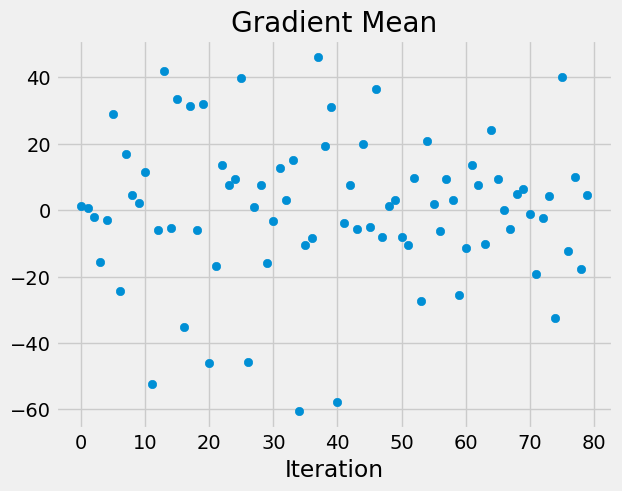

In [23]:
import matplotlib.pyplot as plt

grads_mean = grads.mean(axis=(1,2))
plt.scatter(range(len(grads_mean[:80])), grads_mean[:80])
plt.xlabel('Iteration')
plt.ylabel('')
plt.title('Gradient Mean')
plt.show()


### Gradient clipping

In [24]:
torch.manual_seed(42)
parm=nn.Parameter(torch.randn(2,1))
fake_grads=torch.tensor([[2.5],[0.8]])

#### Value clipping  
Grads stay in [-clip value, +clip value ]

In [25]:
parm.grad=fake_grads.clone()

# Gradient value clipping
nn.utils.clip_grad_value_(parm,clip_value=1.0)
parm.grad.view(-1,)

tensor([1.0000, 0.8000])

#### Norm clipping (Gradient scaling)  

* calculates norm for all gradients together and clip gradients if they exceed the clipping value.
* This preserves the direction of the gradient vector

In [38]:
parm.grad=fake_grads.clone()

# Gradient norm clipping
nn.utils.clip_grad_norm_(parm,max_norm=1.0,norm_type=2)
fake_grads.norm(),parm.grad.view(-1,),parm.grad.norm()

(tensor(2.6249), tensor([0.9524, 0.3048]), tensor(1.0000))

In [39]:
setattr(StepByStep, 'clipping', None)

def set_clip_grad_value(self, clip_value):
    self.clipping = lambda: nn.utils.clip_grad_value_(self.model.parameters(), clip_value=clip_value)
    
def set_clip_grad_norm(self, max_norm, norm_type=2):
    self.clipping = lambda: nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=max_norm, norm_type=norm_type)
    
def remove_clip(self):
    self.clipping = None

def _make_train_step_fn(self):
    # This method does not need ARGS... it can refer to
    # the attributes: self.model, self.loss_fn and self.optimizer

    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        self.model.train()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = self.model(x)
        # Step 2 - Computes the loss
        loss = self.loss_fn(yhat, y)
        # Step 3 - Computes gradients
        loss.backward()

        if callable(self.clipping):
            self.clipping()
        
        # Step 4 - Updates parameters using gradients and learning rate
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

setattr(StepByStep, 'set_clip_grad_value', set_clip_grad_value)
setattr(StepByStep, 'set_clip_grad_norm', set_clip_grad_norm)
setattr(StepByStep, 'remove_clip', remove_clip)
setattr(StepByStep, '_make_train_step_fn', _make_train_step_fn)

In [40]:
def set_clip_backprop(self, clip_value):
    if self.clipping is None:
        self.clipping = []
    for p in self.model.parameters():
        if p.requires_grad:
            func = lambda grad: torch.clamp(grad, -clip_value, clip_value)
            handle = p.register_hook(func)
            self.clipping.append(handle)

def remove_clip(self):
    if isinstance(self.clipping, list):
        for handle in self.clipping:
            handle.remove()
    self.clipping = None

setattr(StepByStep, 'set_clip_backprop', set_clip_backprop)
setattr(StepByStep, 'remove_clip', remove_clip)

In [41]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [42]:
torch.manual_seed(42)
with torch.no_grad():
    model.apply(weights_init)
    
optimizer = optim.SGD(model.parameters(), lr=0.1)

use `set_clip_grad_value` to make sure no gradinets are above 1.0

In [43]:
sbs_reg_clip = StepByStep(model, loss_fn, optimizer)
sbs_reg_clip.set_loaders(train_loader)
sbs_reg_clip.set_clip_grad_value(1.0)
sbs_reg_clip.capture_gradients(['fc1'])
sbs_reg_clip.train(10)
sbs_reg_clip.remove_clip()
sbs_reg_clip.remove_hooks()

  0%|          | 0/10 [00:00<?, ?it/s]

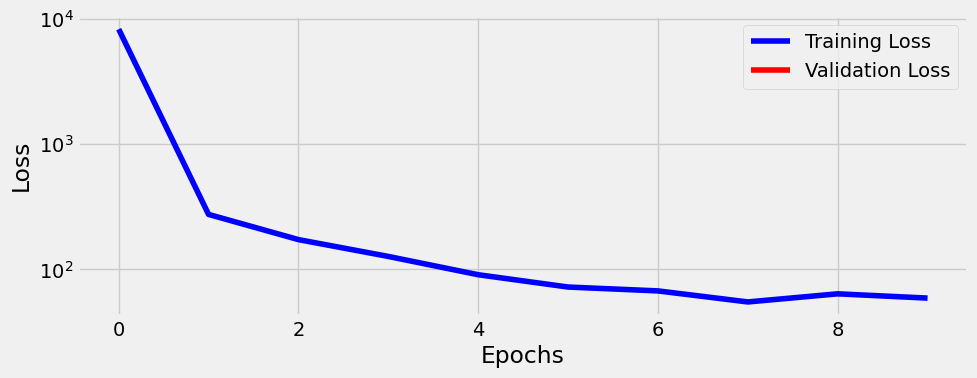

In [44]:
fig=sbs_reg_clip.plot_losses()

In [51]:
avg_grad=np.array(sbs_reg_clip._gradients['fc1']['weight']).mean(axis=(1,2))
avg_grad.min(),avg_grad.max()

(-18.91782176355521, 16.862932171026866)

### Clipping with Hooks

In [53]:
torch.manual_seed(42)
with torch.no_grad():
    model.apply(weights_init)

In [60]:
sbs_reg_clip_hook=StepByStep(model,loss_fn,optimizer)
sbs_reg_clip_hook.set_loaders(train_loader)
sbs_reg_clip_hook.set_clip_backprop(1.0)
sbs_reg_clip_hook.capture_gradients(['fc1'])
sbs_reg_clip_hook.train(10)
sbs_reg_clip_hook.remove_clip()
sbs_reg_clip_hook.remove_hooks()


  0%|          | 0/10 [00:00<?, ?it/s]

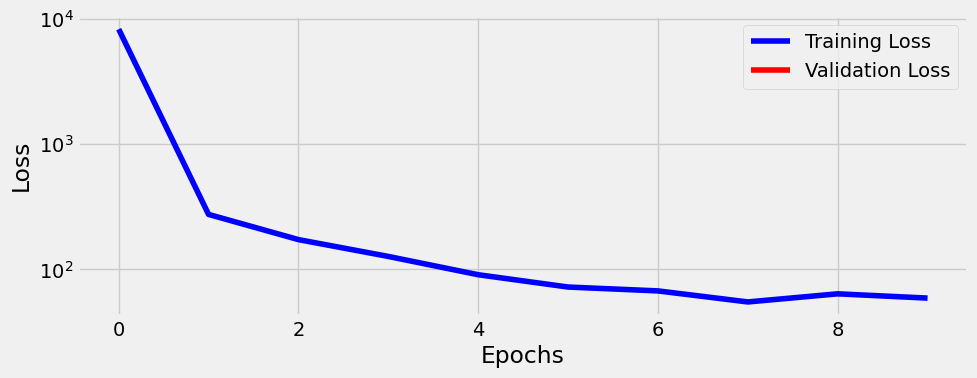

In [61]:
fig=sbs_reg_clip_hook.plot_losses()

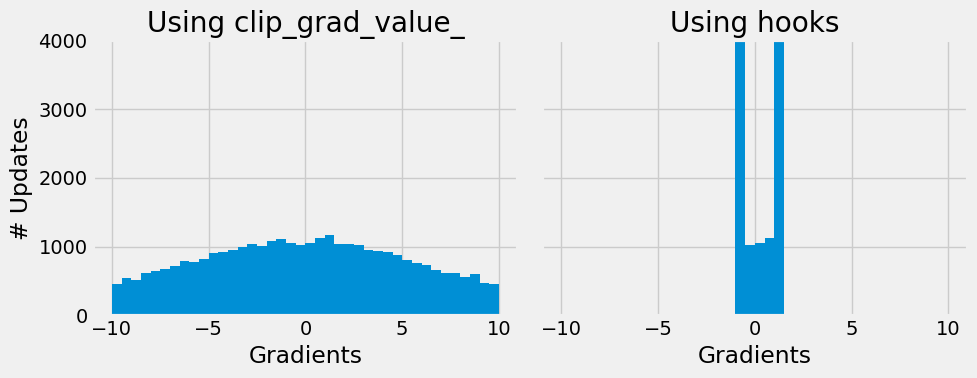

In [62]:
fig = gradient_distrib(sbs_reg_clip, 'fc1', sbs_reg_clip_hook, 'fc1')